# Regression

In [6]:
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert, Luis Pedro Coelho and Matthieu Brucher
# published by PACKT Publishing
#
# It is made available under the MIT License

import numpy as np
from matplotlib import pyplot as plt

Use the magic command `%matplotlib` to see the plots inline:

In [7]:
%matplotlib inline

## Boston dataset

Load the data

In [8]:
!pip install scikit-learn==1.1.3


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [9]:
# deprecated
from sklearn.datasets import load_boston
boston = load_boston()

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California 

In [10]:
# deprecated
# from sklearn.datasets import load_boston
# boston = load_boston()

# maybe good replacement?
'''
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
boston = housing

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
'''

'\nfrom sklearn.datasets import fetch_california_housing\nhousing = fetch_california_housing()\nboston = housing\n\nimport pandas as pd\nimport numpy as np\n\ndata_url = "http://lib.stat.cmu.edu/datasets/boston"\nraw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)\ndata = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])\ntarget = raw_df.values[1::2, 2]\n'

The first regression attempt:

ValueError: Expected 2D array, got scalar array instead:
array=3.561.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

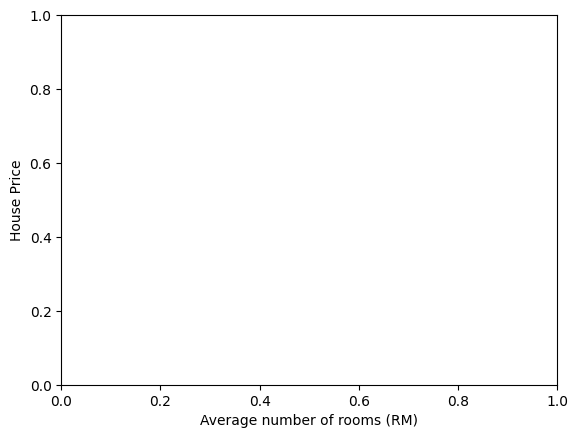

In [12]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)

# Index number five in the number of rooms
x = boston.data[:, 5]
y = boston.target

# lr.fit takes a two-dimensional array as input. We use np.atleast_2d
# to convert from one to two dimensional, then transpose to make sure that the
# format matches:
x = np.transpose(np.atleast_2d(x))
lr.fit(x, y)

fig,ax = plt.subplots()
ax.set_xlabel("Average number of rooms (RM)")
ax.set_ylabel("House Price")
xmin = x.min()
xmax = x.max()
ax.plot([xmin, xmax],
        [lr.predict(xmin), lr.predict(xmax)],
        '-', lw=2, color="#f9a602")
ax.scatter(x, y, s=2)
fig.savefig('Regression_Fig_01.png')

In [13]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, lr.predict(x))
print("Mean squared error (on training data): {:.3}".format(mse))

Mean squared error (on training data): 43.6


In [14]:
rmse = np.sqrt(mse)
print('RMSE (on training data): {}'.format(rmse))

RMSE (on training data): 6.603071389222561


In [15]:
from sklearn.metrics import r2_score
r2 = r2_score(y, lr.predict(x))
print("R2 (on training data): {:.2}".format(r2))

R2 (on training data): 0.48


Repeat, but using all the input variables now

In [16]:
x = boston.data

lr.fit(x,y)

mse = mean_squared_error(y, lr.predict(x))
print("Mean squared error (on training data): {:.3}".format(mse))
rmse = np.sqrt(mse)
print('RMSE (on training data): {}'.format(rmse))
r2 = r2_score(y, lr.predict(x))
print("R2 (on training data): {:.2}".format(r2))

Mean squared error (on training data): 21.9
RMSE (on training data): 4.679191295697282
R2 (on training data): 0.74


To see how well we do, we plot _prediction vs. gold reality_:

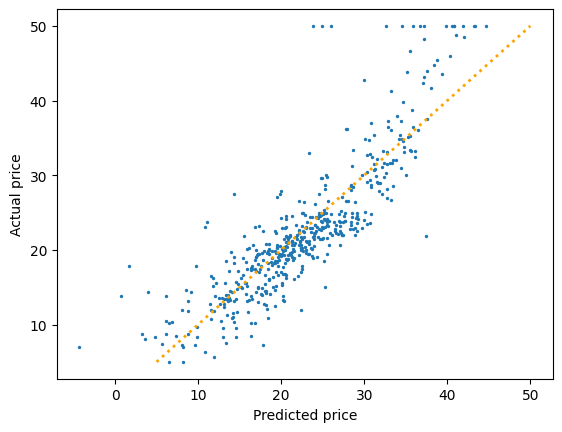

In [17]:
fig,ax = plt.subplots()
ax.set_xlabel('Predicted price')
ax.set_ylabel('Actual price')
ax.plot([y.min(), y.max()], [y.min(), y.max()], ':', lw=2, color="#f9a602")
ax.scatter(lr.predict(x), y, s=2)
fig.savefig("Regression_FIG_02.png")

Now, we will use **cross-validation** for evaluating the regression quality:

In [18]:
from sklearn.model_selection import KFold, cross_val_predict
kf = KFold(n_splits=5)
p = cross_val_predict(lr, x, y, cv=kf)
rmse_cv = np.sqrt(mean_squared_error(p, y))
print('RMSE on 5-fold CV: {:.2}'.format(rmse_cv))

RMSE on 5-fold CV: 6.1


We now compare a few different regression models on _both training data and using cross-validation_:

In [19]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge                              

for name, met in [
        ('linear regression', LinearRegression()),
        ('elastic-net(.5)', ElasticNet(alpha=0.5)),
        ('lasso(.5)', Lasso(alpha=0.5)),
        ('ridge(.5)', Ridge(alpha=0.5)),
]:
    # Fit on the whole data:
    met.fit(x, y)

    # Predict on the whole data:
    p = met.predict(x)
    r2_train = r2_score(y, p)

    kf = KFold(n_splits=5)
    p = np.zeros_like(y)
    for train, test in kf.split(x):
        met.fit(x[train], y[train])
        p[test] = met.predict(x[test])

        r2_cv = r2_score(y, p)
    print('Method: {}'.format(name))
    print('R2 on training: {:.2}'.format(r2_train))
    print('R2 on 5-fold CV: {:.2}'.format(r2_cv))
    print('\n')

Method: linear regression
R2 on training: 0.74
R2 on 5-fold CV: 0.56


Method: elastic-net(.5)
R2 on training: 0.71
R2 on 5-fold CV: 0.64


Method: lasso(.5)
R2 on training: 0.71
R2 on 5-fold CV: 0.59


Method: ridge(.5)
R2 on training: 0.74
R2 on 5-fold CV: 0.58




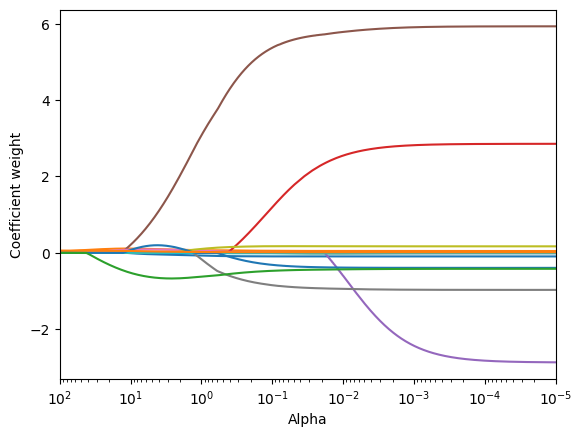

In [20]:
las = Lasso(normalize=True)                            
alphas = np.logspace(-5, 2, 1000)                   
alphas, coefs, _= las.path(x, y, alphas=alphas)     

fig,ax = plt.subplots()                             
ax.plot(alphas, coefs.T)                            
ax.set_xscale('log')                                
ax.set_xlim(alphas.max(), alphas.min())             


ax.set_xlabel('Lasso coefficient path as a function of alpha')                                           
ax.set_xlabel('Alpha')                              
ax.set_ylabel('Coefficient weight')                 
fig.savefig('REGRESSION_FIG_03.png')

## Linear regression with Tensorflow

Let's try and do the same with Tensorflow.

In [21]:
# Batch size, epochs
batch_size = 100
n_epochs = 50000
steps = 1000

In [22]:
# Creation of the scaffolding

import tensorflow as tf
tf.reset_default_graph()

x = boston.data[:,5][:,None]
y = np.reshape(boston.target, (-1, 1))

nb_features = x.shape[1]

X = tf.placeholder(shape=[None, nb_features], dtype=tf.float32, name="X")
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name="y")

A = tf.Variable(tf.random_normal(shape=[nb_features, 1]), name="A")
b = tf.Variable(tf.random_normal(shape=[1,1]), name="b")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Creation of the graph
model_output = tf.matmul(X, A) + b

loss = tf.reduce_mean(tf.square(Y - model_output))

# Uncomment to get Ridge or Lasso
"""
beta = 0.005
regularizer = tf.nn.l2_loss(A)
loss = loss + beta * regularizer
"""
"""
beta = 0.5
regularizer = tf.reduce_mean(tf.abs(A))
loss = loss + beta * regularizer
"""

grad_speed = 1e-3
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

In [ ]:
# Run the optimization
loss_vec = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(x))
        for j in range(0, len(x), batch_size):
            batch = permut[j:j+batch_size]
            Xs = x[batch]
            Ys = y[batch]

            sess.run(train_step, feed_dict={X: Xs, Y: Ys})
            temp_loss = sess.run(loss, feed_dict={X: Xs, Y: Ys})
        
        if epoch % steps == steps - 1:
            temp_loss = sess.run(loss, feed_dict={X: x, Y: y})
            loss_vec.append(temp_loss)

            (A_, b_) = sess.run([A, b])
            print('Epoch #%i  A = %s b = %s' % (epoch, np.transpose(A_), b_))
            print('Loss = %.8f' % temp_loss)
            print("")


    [slope, y_intercept] = sess.run([A, b])
    prediction = sess.run(model_output, feed_dict={X: x})
    mse = mean_squared_error(y, prediction)
    print("Mean squared error (on training data): {:.3}".format(mse))
    rmse = np.sqrt(mse)
    print('RMSE (on training data): {}'.format(rmse))
    r2 = r2_score(y, prediction)
    print("R2 (on training data): {:.2}".format(r2))

best_fit = []
for i in x:
    best_fit.append(slope[0]*i+y_intercept[0])

In [ ]:
# Plot 1D best fit

fig,ax = plt.subplots()
ax.set_xlabel("Average number of rooms (RM)")
ax.set_ylabel("House Price")

ax.scatter(x, y, s=2, label='Data Points')
ax.plot(x, np.array(best_fit), '-', lw=2, color="#f9a602", label='Best fit line')
ax.legend(loc='upper left')

fig.savefig('REGRESSION_FIG_06.png')

# Plot loss over time
plt.figure()
fig,ax = plt.subplots()
ax.set_title('Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(loss_vec, 'k-')

fig.savefig('REGRESSION_FIG_07.png')

What happens if we move to use all the features?

In [23]:
# Creation of the scaffolding

import tensorflow as tf
tf.reset_default_graph()

x = boston.data
y = np.reshape(boston.target, (-1, 1))

nb_features = x.shape[1]

X = tf.placeholder(shape=[None, nb_features], dtype=tf.float32, name="X")
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32, name="y")

A = tf.Variable(tf.random_normal(shape=[nb_features, 1]), name="A")
b = tf.Variable(tf.random_normal(shape=[1,1]), name="b")

ModuleNotFoundError: No module named 'tensorflow'

In [24]:
# Creation of the graph
model_output = tf.matmul(X, A) + b

loss = tf.reduce_mean(tf.square(Y - model_output))

# Uncomment to get Ridge or Lasso
"""
beta = 0.005
regularizer = tf.nn.l2_loss(A)
loss = loss + beta * regularizer
"""
"""
beta = 0.5
regularizer = tf.reduce_mean(tf.abs(A))
loss = loss + beta * regularizer
"""

grad_speed = 5e-7
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

NameError: name 'tf' is not defined

In [25]:
# Run the optimization
loss_vec = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(x))
        for j in range(0, len(x), batch_size):
            batch = permut[j:j+batch_size]
            Xs = x[batch]
            Ys = y[batch]

            sess.run(train_step, feed_dict={X: Xs, Y: Ys})
            temp_loss = sess.run(loss, feed_dict={X: Xs, Y: Ys})
        
        if epoch % steps == steps - 1:
            temp_loss = sess.run(loss, feed_dict={X: x, Y: y})
            loss_vec.append(temp_loss)

            (A_, b_) = sess.run([A, b])
            print('Epoch #%i  A = %s b = %s' % (epoch, np.transpose(A_), b_))
            print('Loss = %.8f' % temp_loss)
            print("")


    [slope, y_intercept] = sess.run([A, b])
    prediction = sess.run(model_output, feed_dict={X: x})
    mse = mean_squared_error(y, prediction)
    print("Mean squared error (on training data): {:.3}".format(mse))
    rmse = np.sqrt(mse)
    print('RMSE (on training data): {}'.format(rmse))
    r2 = r2_score(y, prediction)
    print("R2 (on training data): {:.2}".format(r2))

best_fit = []
for i in x:
    best_fit.append(slope[0]*i+y_intercept[0])

NameError: name 'tf' is not defined

<Figure size 640x480 with 0 Axes>

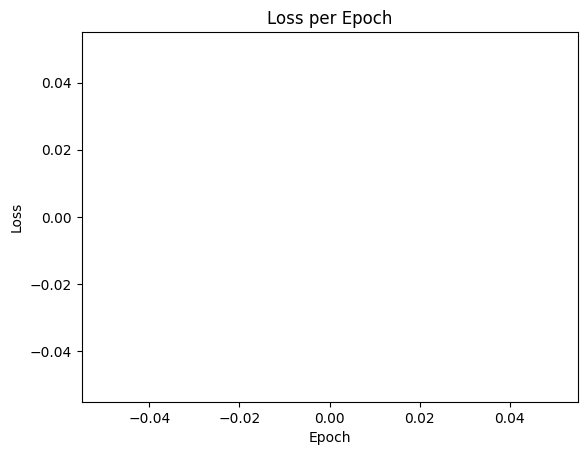

In [26]:
# Plot loss over time
plt.figure()
fig,ax = plt.subplots()
ax.set_title('Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(loss_vec, 'k-')

fig.savefig('REGRESSION_FIG_08.png')

## E2006 Dataset

Load data:


In [27]:
from sklearn.datasets import load_svmlight_file
data, target = load_svmlight_file('data/E2006.train')

FileNotFoundError: [Errno 2] No such file or directory: 'data/E2006.train'

Compute error on training data to demonstrate that we can obtain near perfect scores:

In [28]:
lr = LinearRegression()
lr.fit(data, target)
pred = lr.predict(data) 

print('RMSE on training, {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('R2 on training, {:.2}'.format(r2_score(target, pred)))

NameError: name 'data' is not defined

However, we do not do so well on cross-validation:

In [29]:
kf = KFold(n_splits=5)
pred = cross_val_predict(lr, data, target, cv=kf)

print('RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('R2 on testing (5 fold), {:.2}'.format(r2_score(target, pred)))

NameError: name 'data' is not defined

Now, we try _an Elastic net_:

In [30]:
# Edit the lines below if you want to switch method:                                                     
met = ElasticNet(alpha=0.1)
met.fit(data, target)
pred = met.predict(data)

print('[EN 0.1] RMSE on training: {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN 0.1] R2 on training: {:.2}'.format(r2_score(target, pred)))

NameError: name 'data' is not defined

Not a perfect prediction on the training data anymore, but let us check the value on cross-validation:

In [31]:
pred = cross_val_predict(met, data, target, cv=kf)

print('[EN 0.1] RMSE on testing (5 fold): {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN 0.1] R2 on testing (5 fold): {:.2}'.format(r2_score(target, pred)))

NameError: name 'data' is not defined

We now use `ElasticNetCV` to set parameters automatically:

In [32]:
from sklearn.linear_model import ElasticNetCV
# Construct an ElasticNetCV object (use all available CPUs)
met = ElasticNetCV(n_jobs=-1)

met.fit(data, target)
pred = met.predict(data)
print('[EN CV] RMSE on training, {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN CV] R2 on training, {:.2}'.format(r2_score(target, pred)))

pred = cross_val_predict(met, data, target, cv=kf)
print('[EN CV] RMSE on testing (5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN CV] R2 on testing (5 fold), {:.2}'.format(r2_score(target, pred)))

NameError: name 'data' is not defined

This is a a pretty good general-purpose regression object:

In [33]:
# Construct an ElasticNetCV object (use all available CPUs)
met = ElasticNetCV(n_jobs=-1, l1_ratio=[.01, .05, .25, .5, .75, .95, .99])

pred = cross_val_predict(met, data, target, cv=kf)

print('[EN CV l1_ratio] RMSE on testing(5 fold), {:.2}'.format(np.sqrt(mean_squared_error(target, pred))))
print('[EN CV l1_ratio] R2 on testing (5 fold), {:.2}'.format(r2_score(target, pred)))

NameError: name 'data' is not defined

Now the final result:

NameError: name 'target' is not defined

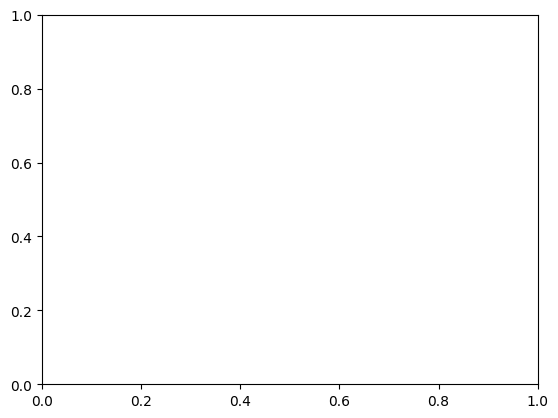

In [34]:
fig, ax = plt.subplots()
ax.scatter(target, pred, c='k', s=1)
ax.plot([-5,-1], [-5,-1], 'r-', lw=2)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
fig.savefig('REGRESSION_FIG_05.png')